In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from functions import *
from Layer import Layer, Input
from utils import *

In [2]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv("/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/ML-CUP23-TR.csv", names=names, comment='#')

In [3]:
targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

In [4]:
df = df.sample(frac=1)

In [5]:
prova = df[0:750]


In [6]:
X_train, y_train = prova[features].to_numpy().T, prova[targets].to_numpy().T
X_test, y_test = df[750:][features].to_numpy().T, df[750:][targets].to_numpy().T

In [7]:
X_train.shape

(10, 750)

In [8]:
early_stopping = {'patience' : 150,
                  'monitor' : 'val_MRAE',
                  'verbose' : 0,
                  'compare_function': np.greater_equal}

reduce_eta = {'patience' : 75,
              'monitor' : 'val_MRAE',
              'factor' : 0.5,
              'verbose' : 0,
              'compare_function': np.greater_equal}

callbacks = {'early_stopping': None,
             'reduce_eta': None}

In [16]:
input_layer = Input(10)
hidden_layer = Layer(input_layer, 5, 'relu')
output_layer = Layer(hidden_layer, 3, 'lin')

model = NeuralNetwork(input_layer, output_layer, loss = 'MSE', metrics=[MRAE])
history = model.train(X_train, y_train, epochs = 5000,
                                    eta = 0.02, lam = 0.01, n_batch = 31,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 3.512e+02, val_loss: 3.663e+02; train_MRAE: 2.683e+00, val_MRAE: 2.690e+00  lr : 0.5
Epoch 1: train_loss: 2.104e+02, val_loss: 2.130e+02; train_MRAE: 1.578e+00, val_MRAE: 1.404e+00  lr : 0.5
Epoch 2: train_loss: 1.491e+02, val_loss: 1.505e+02; train_MRAE: 1.263e+00, val_MRAE: 1.136e+00  lr : 0.5
Epoch 3: train_loss: 1.164e+02, val_loss: 1.172e+02; train_MRAE: 1.287e+00, val_MRAE: 8.468e-01  lr : 0.5
Epoch 4: train_loss: 9.658e+01, val_loss: 9.678e+01; train_MRAE: 1.117e+00, val_MRAE: 8.382e-01  lr : 0.5
Epoch 5: train_loss: 8.337e+01, val_loss: 8.343e+01; train_MRAE: 9.231e-01, val_MRAE: 8.286e-01  lr : 0.5
Epoch 6: train_loss: 7.374e+01, val_loss: 7.379e+01; train_MRAE: 1.046e+00, val_MRAE: 7.519e-01  lr : 0.5
Epoch 7: train_loss: 6.641e+01, val_loss: 6.640e+01; train_MRAE: 9.781e-01, val_MRAE: 7.346e-01  lr : 0.5
Epoch 8: train_loss: 6.092e+01, val_loss: 6.070e+01; train_MRAE: 8.909e-01, val_MRAE: 7.053e-01  lr : 0.5
Epoch 9: train_loss: 5.640e+01, val_loss: 5.61

KeyboardInterrupt: 

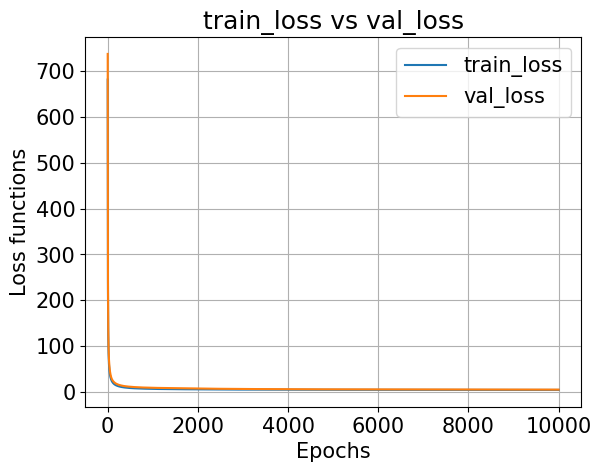

In [10]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

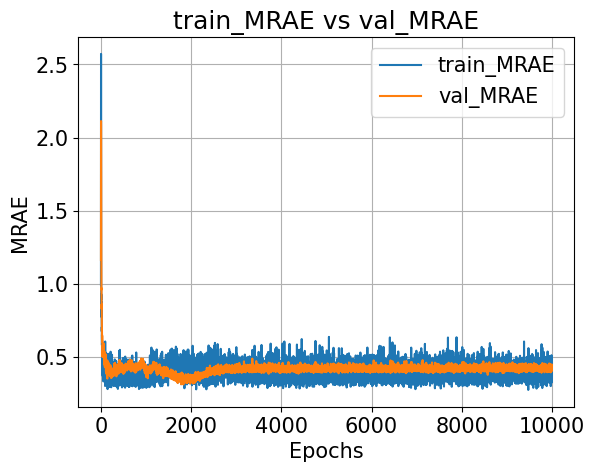

In [12]:
plt.plot(history['train_MRAE'],label='train_MRAE')
plt.plot(history['val_MRAE'], label='val_MRAE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MRAE', size=15)
plt.title('train_MRAE vs val_MRAE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

In [14]:
y_pred = model.predict(X_test)

In [17]:
def MRAE(y_pred, y_true):
    return (np.abs((y_pred - y_true)/y_true)/y_true.shape[1]).reshape(y_pred.shape)

In [21]:
print(MRAE(y_pred, y_test).sum(axis=1))

[0.43683883 0.74176801 0.28836645]


In [26]:
y_pred

array([[-6.31399933e+01,  1.00584848e+01, -2.20928726e+01,
         1.46334969e+01, -4.52762616e+01,  5.45906328e+00,
         1.37026292e+01,  5.37975503e+00, -4.18525072e+01,
        -5.79709505e+00,  2.88052917e+00, -6.06706445e+01,
         1.96625231e+01, -1.84693285e+01, -5.24472970e+01,
         1.37635362e+01,  9.39527167e+00,  1.01769095e+01,
         1.79786466e+01,  4.73164074e+00, -4.66390935e+01,
        -4.88824304e+01,  1.04437725e+01, -5.10265122e+01,
         1.30147135e+01,  8.67490970e+00, -6.81346500e+00,
        -3.49558000e+01, -1.98430827e+01,  3.12233647e+00,
        -2.57593136e+01, -1.43222870e+01,  1.50742641e+01,
        -6.17853880e+00, -5.18907763e+01, -1.41364443e+00,
         1.20895218e+01, -4.14112045e+01, -6.92657480e+00,
         2.37447288e-01,  1.72326139e+01,  1.62146929e+01,
        -3.29963313e+01, -7.88331183e+00, -3.35926341e+01,
        -2.98882488e+01, -2.75586725e+01, -6.76953575e+01,
        -2.35003479e+01, -1.89414674e+01,  1.43657766e+0

In [27]:
y_test

array([[-5.92691600e+01,  8.44340900e+00, -2.02791100e+01,
         1.17177690e+01, -4.70271200e+01,  3.55720800e+00,
         7.27446600e+00,  3.92465110e+00, -4.12744330e+01,
        -4.32865330e+00,  2.46581340e+00, -5.69650540e+01,
         1.52386680e+01, -2.60913640e+01, -5.25694920e+01,
         1.10257860e+01,  7.41220240e+00,  7.88651850e+00,
         1.53895530e+01,  4.00796030e+00, -4.41600840e+01,
        -4.87955320e+01,  8.15753900e+00, -4.39277650e+01,
         1.04738000e+01,  6.94837140e+00, -1.36668540e+01,
        -3.21486800e+01, -1.99398170e+01,  4.10212560e+00,
        -2.18099060e+01, -1.57835520e+01,  1.22273580e+01,
        -7.57110300e+00, -4.71964570e+01,  7.71696940e-02,
         1.05282345e+01, -3.81073570e+01, -1.27991110e+01,
         1.19619580e-02,  1.57958740e+01,  1.56626410e+01,
        -3.10060460e+01, -8.26430500e+00, -3.48149830e+01,
        -3.06962030e+01, -2.27842860e+01, -6.48755800e+01,
        -2.15708030e+01, -1.99330640e+01,  1.18855950e+0

In [20]:
a = np.array([[1,1,1],[1,1,1]])
print(a.sum())

6
